In [322]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import os
from pathlib import Path

In [593]:
class TileCoder:
    def __init__(self, num_tilings, tiles_per_dimension, env_low, env_high):
        self.num_tilings = num_tilings
        self.tiles_per_dimension = tiles_per_dimension
        self.env_low = np.array(env_low)
        self.env_high = np.array(env_high)
        self.tile_width = (self.env_high - self.env_low) / (tiles_per_dimension - 1)
        self.offsets = [(self.tile_width / num_tilings) * i for i in range(num_tilings)]
    
    def get_tile_code(self, observation):
        observation = np.array(observation)
        tile_codes = np.zeros(self.num_tilings * self.tiles_per_dimension**len(observation))
        for tiling in range(self.num_tilings):
            indices = []
            for i, val in enumerate(observation):
                index = int((val - self.env_low[i] + self.offsets[tiling][i]) / self.tile_width[i])
                index = min(index, self.tiles_per_dimension - 1)  # Ensure index is within bounds
                indices.append(index)
            tiling_index = tiling * (self.tiles_per_dimension**len(observation))
            flat_index = tiling_index + sum([indices[i] * (self.tiles_per_dimension ** i) for i in range(len(indices))])
            tile_codes[int(flat_index)] = 1
        return tile_codes

# Q learning

In [10]:
class QLearning:
    def __init__(self, num_actions, tile_coder, alpha=0.1, gamma=0.99):
        self.num_actions = num_actions
        self.tile_coder = tile_coder
        self.alpha = alpha
        self.gamma = gamma
        num_state_dimensions = len(env.observation_space.low)  # Adjust based on the number of state variables
        num_features = tile_coder.num_tilings * (tile_coder.tiles_per_dimension ** num_state_dimensions)
        self.theta = np.random.uniform(-0.001, 0.001, (num_actions, num_features))

    def choose_action(self, observation, epsilon=0.1):
        if np.random.rand() < epsilon:
            return np.random.randint(self.num_actions)
        else:
            q_values = self.get_q_values(observation)
            return np.argmax(q_values)

    def get_q_values(self, observation):
        features = self.tile_coder.get_tile_code(observation)
        return np.dot(self.theta, features)

    def update(self, observation, action, reward, next_observation):
        features = self.tile_coder.get_tile_code(observation)
        next_features = self.tile_coder.get_tile_code(next_observation)
        q_values_next = np.dot(self.theta, next_features)
        target = reward + self.gamma * np.max(q_values_next)
        td_error = target - np.dot(self.theta[action], features)
        self.theta[action] += self.alpha * td_error * features


## Q learning on MountainCar-v0

In [47]:
# Initialize the MountainCar-v0 environment
env = gym.make('MountainCar-v0')
env.seed(0)  # For reproducibility

# Environment parameters
env_low = env.observation_space.low
env_high = env.observation_space.high
num_actions = env.action_space.n

# Initialize tile coder
tile_coder = TileCoder(num_tilings=2, tiles_per_dimension=10, env_low=env_low, env_high=env_high)

# Parameters for the experiments
epsilons = [0.01, 0.03, 0.05]
alphas = [1/4, 1/8, 1/16]
num_trials = 50
num_episodes = 1000
gamma = 0.99

results = {}

# Function to run a single trial
def run_trial(alpha, epsilon):
    q_learning = QLearning(num_actions, tile_coder, alpha=alpha, gamma=gamma)
    episode_rewards = np.zeros(num_episodes)
    for episode in range(num_episodes):
        total_reward = 0
        observation = env.reset()
        done = False
        while not done:
            action = q_learning.choose_action(observation, epsilon)
            next_observation, reward, done, info = env.step(action)
            q_learning.update(observation, action, reward, next_observation)
            observation = next_observation
            total_reward += reward
        episode_rewards[episode] = total_reward
    return episode_rewards

# Run experiments
setting_id = 1
for epsilon in epsilons:
    for alpha in alphas:
        trial_rewards = []
        for trial in tqdm(range(num_trials), desc=f'Alpha: {alpha}, Epsilon: {epsilon}'):
            trial_rewards.append(run_trial(alpha, epsilon))
        
        trial_rewards = np.array(trial_rewards)
        
        # Calculate statistics for the trials across all episodes
        upper_quantiles = np.quantile(trial_rewards, 0.75, axis=0)
        means = np.mean(trial_rewards, axis=0)
        lower_quantiles = np.quantile(trial_rewards, 0.25, axis=0)
        
        setting_key = f"setting{setting_id}"
        results[setting_key] = {
            "epsilon": epsilon,
            "alpha": alpha,
            "50_trials": {
                "1000_episodes_upper_quantile": upper_quantiles.tolist(),
                "1000_episodes_mean": means.tolist(),
                "1000_episodes_lower_quantile": lower_quantiles.tolist()
            }
        }
        setting_id += 1

# Save results to a JSON file for MountainCar-v0
output_path = './test/q_learning_task1.json'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
with open(output_path, 'w') as fp:
    json.dump(results, fp, indent=4)

print(f"Experiment results for MountainCar-v0 saved to {output_path}")

Alpha: 0.0625, Epsilon: 0.05: 100%|██████████| 50/50 [03:38<00:00,  4.37s/it]

Experiment results for MountainCar-v0 saved to ./test/q_learning_task1.json


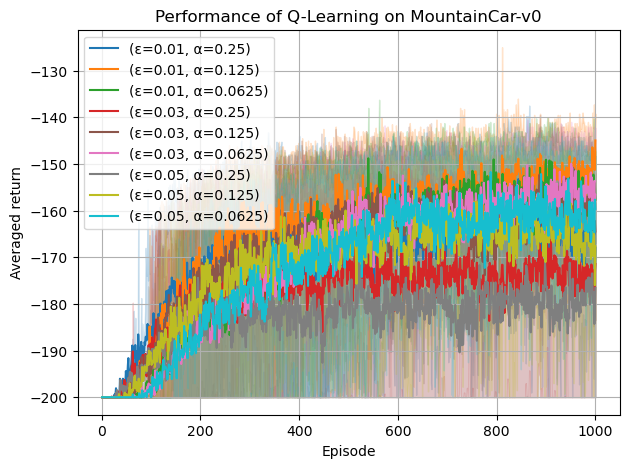

In [648]:
# Load the JSON data from the file
file_path = './test/q_learning_task1.json'  # Make sure to replace this with the actual path to your JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Initialize the figure
plt.figure(figsize=(7,5))

# Define a color palette for visual distinction
color_palette = plt.cm.tab10(np.linspace(0, 1, len(data)))

# Assuming episodes range from 1 to 1000
episodes = np.arange(1, 1001)

for i, (setting, details) in enumerate(data.items()):
    # Extract performance data
    mean_performance = details['50_trials']['1000_episodes_mean']
    upper_quantile_performance = details['50_trials']['1000_episodes_upper_quantile']
    lower_quantile_performance = details['50_trials']['1000_episodes_lower_quantile']
    
    # Plot mean performance with a specific color and solid line
    plt.plot(episodes, mean_performance, label=f"(ε={details['epsilon']}, α={details['alpha']})",
             color=color_palette[i % len(color_palette)], linestyle='-')
    
    # Add shaded interquantile region
    plt.fill_between(episodes, lower_quantile_performance, upper_quantile_performance, color=color_palette[i % len(color_palette)], alpha=0.2)

plt.title('Performance of Q-Learning on MountainCar-v0')
plt.xlabel('Episode')
plt.ylabel('Averaged return')
plt.legend()
plt.grid(True)
plt.show()

## Q learning on CartPole-v1

In [49]:
# CartPole-v1 environment parameters with assumed bounds
cart_position_bounds = [-4.8, 4.8]
pole_angle_bounds = [-0.418, 0.418]  # Approximate bounds in radians
cart_velocity_bounds = [-2.0, 2.0]  # Assumed reasonable bounds for cart velocity
pole_angular_velocity_bounds = [-2.0, 2.0]  # Assumed reasonable bounds for pole angular velocity

# Combine the defined and assumed bounds into env_low and env_high
env_low = np.array([cart_position_bounds[0], cart_velocity_bounds[0], pole_angle_bounds[0], pole_angular_velocity_bounds[0]])
env_high = np.array([cart_position_bounds[1], cart_velocity_bounds[1], pole_angle_bounds[1], pole_angular_velocity_bounds[1]])

# Initialize the CartPole-v1 environment
env = gym.make('CartPole-v1')
env.seed(0)
num_actions = env.action_space.n

# Initialize tile coder
tile_coder = TileCoder(num_tilings=4, tiles_per_dimension=10, env_low=env_low, env_high=env_high)

# Parameters for the experiments
epsilons = [0.01, 0.03, 0.05]
alphas = [1/4, 1/8, 1/16]
num_trials = 50
num_episodes = 1000
gamma = 0.99

results = {}

# Function to run a single trial for CartPole-v1
def run_trial(alpha, epsilon):
    q_learning = QLearning(num_actions, tile_coder, alpha=alpha, gamma=gamma)
    episode_rewards = np.zeros(num_episodes)
    for episode in range(num_episodes):
        total_reward = 0
        observation = env.reset()
        done = False
        while not done:
            action = q_learning.choose_action(observation, epsilon)
            next_observation, reward, done, info = env.step(action)
            q_learning.update(observation, action, reward, next_observation)
            observation = next_observation
            total_reward += reward
        episode_rewards[episode] = total_reward
    return episode_rewards

# Run experiments for CartPole-v1
setting_id = 1
for epsilon in epsilons:
    for alpha in alphas:
        trial_rewards = []
        for trial in tqdm(range(num_trials), desc=f'Alpha: {alpha}, Epsilon: {epsilon}'):
            trial_rewards.append(run_trial(alpha, epsilon))
        
        trial_rewards = np.array(trial_rewards)
        
        # Calculate statistics for the trials across all episodes
        upper_quantiles = np.quantile(trial_rewards, 0.75, axis=0)
        means = np.mean(trial_rewards, axis=0)
        lower_quantiles = np.quantile(trial_rewards, 0.25, axis=0)
        
        setting_key = f"setting{setting_id}"
        results[setting_key] = {
            "epsilon": epsilon,
            "alpha": alpha,
            "50_trials": {
                "1000_episodes_upper_quantile": upper_quantiles.tolist(),
                "1000_episodes_mean": means.tolist(),
                "1000_episodes_lower_quantile": lower_quantiles.tolist()
            }
        }
        setting_id += 1

# Save results to a JSON file for CartPole-v1
output_path = './test/q_learning_task2.json'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
with open(output_path, 'w') as fp:
    json.dump(results, fp, indent=4)

print(f"Experiment results for CartPole-v1 saved to {output_path}")

Alpha: 0.0625, Epsilon: 0.05: 100%|██████████| 50/50 [27:35<00:00, 33.12s/it]

Experiment results for CartPole-v1 saved to ./test/q_learning_task2.json


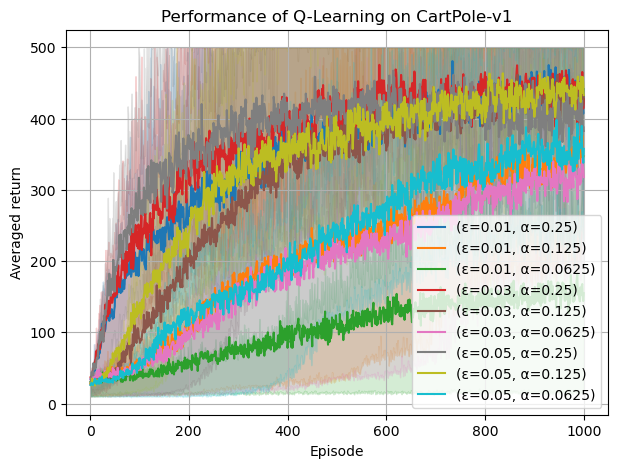

In [652]:
# Load the JSON data from the file
file_path = './test/q_learning_task2.json'  # Make sure to replace this with the actual path to your JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Initialize the figure
plt.figure(figsize=(7, 5))

# Define a color palette for visual distinction
color_palette = plt.cm.tab10(np.linspace(0, 1, len(data)))

# Assuming episodes range from 1 to 1000
episodes = np.arange(1, 1001)

for i, (setting, details) in enumerate(data.items()):
    # Extract performance data
    mean_performance = details['50_trials']['1000_episodes_mean']
    upper_quantile_performance = details['50_trials']['1000_episodes_upper_quantile']
    lower_quantile_performance = details['50_trials']['1000_episodes_lower_quantile']
    
    # Plot mean performance with a specific color and solid line
    plt.plot(episodes, mean_performance, label=f"(ε={details['epsilon']}, α={details['alpha']})",
             color=color_palette[i % len(color_palette)], linestyle='-')
    
    # Add shaded interquantile region
    plt.fill_between(episodes, lower_quantile_performance, upper_quantile_performance, color=color_palette[i % len(color_palette)], alpha=0.2)

plt.title('Performance of Q-Learning on CartPole-v1')
plt.xlabel('Episode')
plt.ylabel('Averaged return')
plt.legend()
plt.grid(True)
plt.show()

# Expected Sarsa

In [25]:
class Expected_Sarsa:
    def __init__(self, num_actions, tile_coder, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.num_actions = num_actions
        self.tile_coder = tile_coder
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        num_features = tile_coder.num_tilings * (tile_coder.tiles_per_dimension ** len(env.observation_space.low))
        self.theta = np.random.uniform(-0.001, 0.001, (num_actions, num_features))
        
    def get_q_values(self, observation):
        features = self.tile_coder.get_tile_code(observation)
        return np.dot(self.theta, features)
    
    def choose_action(self, observation):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            q_values = self.get_q_values(observation)
            return np.argmax(q_values)
    
    def update(self, observation, action, reward, next_observation, next_action):
        features = self.tile_coder.get_tile_code(observation)
        next_features = self.tile_coder.get_tile_code(next_observation)
        
        # Calculate the expected Q value for the next state using the policy
        q_values_next = self.get_q_values(next_observation)
        expected_q = np.dot(self.get_policy(q_values_next), q_values_next)
        
        # Compute the target for the TD error
        target = reward + self.gamma * expected_q
        td_error = target - np.dot(self.theta[action], features)
        self.theta[action] += self.alpha * td_error * features
    
    def get_policy(self, q_values):
        # Implement an epsilon-greedy policy that returns the probability distribution over actions
        policy = np.ones(self.num_actions) * self.epsilon / self.num_actions
        best_action = np.argmax(q_values)
        policy[best_action] += (1.0 - self.epsilon)
        return policy

## Expected Sarsa on MountainCar-v0

In [51]:
# Initialize the environment
env = gym.make('MountainCar-v0')
env.seed(0)  # Ensure reproducibility

# Environment parameters
env_low = env.observation_space.low
env_high = env.observation_space.high
num_actions = env.action_space.n

# Initialize tile coder
tile_coder = TileCoder(num_tilings=2, tiles_per_dimension=10, env_low=env_low, env_high=env_high)

# Parameter settings for the experiments
epsilons = [0.01, 0.03, 0.05]
alphas = [1/4, 1/8, 1/16]
num_trials = 50
num_episodes = 1000

# Results dictionary
results = {}

# Test the performance on 9 parameter settings
setting_id = 1
for epsilon in epsilons:
    for alpha in alphas:
        setting_key = f"setting{setting_id}"
        all_rewards = []  # Collect all rewards for quantile and mean calculation

        for trial in tqdm(range(num_trials), desc=f'Alpha: {alpha}, Epsilon: {epsilon}'):
            agent = Expected_Sarsa(num_actions, tile_coder, alpha, gamma=0.99, epsilon=epsilon)
            trial_rewards = []
            
            for episode in range(num_episodes):
                state = env.reset()
                action = agent.choose_action(state)
                total_reward = 0
                done = False
                
                while not done:
                    next_state, reward, done, _ = env.step(action)
                    next_action = agent.choose_action(next_state)
                    agent.update(state, action, reward, next_state, next_action)
                    state = next_state
                    action = next_action
                    total_reward += reward
                
                trial_rewards.append(total_reward)
            
            all_rewards.append(trial_rewards)

        all_rewards = np.array(all_rewards)
        upper_quantile = np.quantile(all_rewards, 0.75, axis=0)
        mean_rewards = np.mean(all_rewards, axis=0)
        lower_quantile = np.quantile(all_rewards, 0.25, axis=0)
        
        results[setting_key] = {
            "epsilon": epsilon,
            "alpha": alpha,
            "50_trials": {
                "1000_episodes_upper_quantile": upper_quantile.tolist(),
                "1000_episodes_mean": mean_rewards.tolist(),
                "1000_episodes_lower_quantile": lower_quantile.tolist()
            }
        }
        setting_id += 1

# Ensure the directory exists
output_dir = './test'
os.makedirs(output_dir, exist_ok=True)

# Output results to a JSON file
output_path = os.path.join(output_dir, 'sarsa_task1.json')
with open(output_path, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {output_path}")

Alpha: 0.0625, Epsilon: 0.05: 100%|██████████| 50/50 [04:27<00:00,  5.35s/it]

Results saved to ./test/sarsa_task1.json


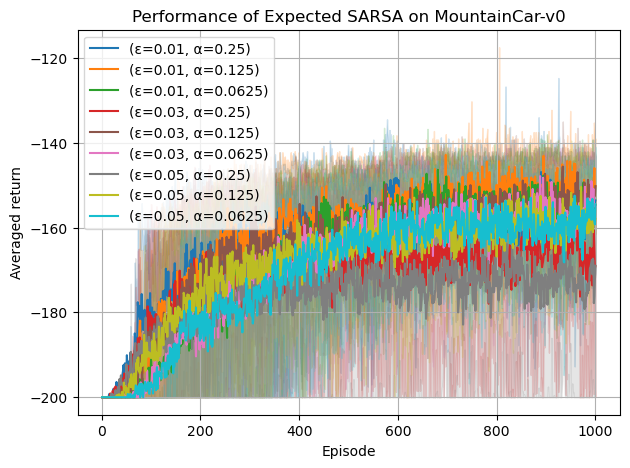

In [650]:
# Load the JSON data from the file
file_path = './test/sarsa_task1.json'  # Make sure to replace this with the actual path to your JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Initialize the figure
plt.figure(figsize=(7, 5))

# Define a color palette for visual distinction
color_palette = plt.cm.tab10(np.linspace(0, 1, len(data)))

# Assuming episodes range from 1 to 1000
episodes = np.arange(1, 1001)

for i, (setting, details) in enumerate(data.items()):
    # Extract performance data
    mean_performance = details['50_trials']['1000_episodes_mean']
    upper_quantile_performance = details['50_trials']['1000_episodes_upper_quantile']
    lower_quantile_performance = details['50_trials']['1000_episodes_lower_quantile']
    
    # Plot mean performance with a specific color and solid line
    plt.plot(episodes, mean_performance, label=f"(ε={details['epsilon']}, α={details['alpha']})",
             color=color_palette[i % len(color_palette)], linestyle='-')
    
    # Add shaded interquantile region
    plt.fill_between(episodes, lower_quantile_performance, upper_quantile_performance, color=color_palette[i % len(color_palette)], alpha=0.2)

plt.title('Performance of Expected SARSA on MountainCar-v0')
plt.xlabel('Episode')
plt.ylabel('Averaged return')
plt.legend()
plt.grid(True)
plt.show()

## Expected Sarsa on CartPole-v1

In [53]:
# Initialize the CartPole-v1 environment
env = gym.make('CartPole-v1')
env.seed(0)  # Ensure reproducibility

# Environment parameters for CartPole-v1
env_low = np.array([-2.4, -4, -0.418, -4])  # These are rough approximations and might need adjustments
env_high = np.array([2.4, 4, 0.418, 4])

num_actions = env.action_space.n

# Initialize tile coder with adjusted parameters
tile_coder = TileCoder(num_tilings=4, tiles_per_dimension=10, env_low=env_low, env_high=env_high)

# Parameter settings for the experiments
epsilons = [0.01, 0.03, 0.05]
alphas = [1/4, 1/8, 1/16]
num_trials = 50
num_episodes = 1000

# Results dictionary
results = {}

# Test the performance on 9 parameter settings
setting_id = 1
for epsilon in epsilons:
    for alpha in alphas:
        setting_key = f"setting{setting_id}"
        all_rewards = []  # Collect all rewards for quantile and mean calculation

        for trial in tqdm(range(num_trials), desc=f'Alpha: {alpha}, Epsilon: {epsilon}'):
            agent = Expected_Sarsa(num_actions, tile_coder, alpha, gamma=0.99, epsilon=epsilon)
            trial_rewards = []
            
            for episode in range(num_episodes):
                state = env.reset()
                action = agent.choose_action(state)
                total_reward = 0
                done = False
                
                while not done:
                    next_state, reward, done, _ = env.step(action)
                    next_action = agent.choose_action(next_state)
                    agent.update(state, action, reward, next_state, next_action)
                    state = next_state
                    action = next_action
                    total_reward += reward
                
                trial_rewards.append(total_reward)
            
            all_rewards.append(trial_rewards)

        all_rewards = np.array(all_rewards)
        upper_quantile = np.quantile(all_rewards, 0.75, axis=0)
        mean_rewards = np.mean(all_rewards, axis=0)
        lower_quantile = np.quantile(all_rewards, 0.25, axis=0)
        
        results[setting_key] = {
            "epsilon": epsilon,
            "alpha": alpha,
            "50_trials": {
                "1000_episodes_upper_quantile": upper_quantile.tolist(),
                "1000_episodes_mean": mean_rewards.tolist(),
                "1000_episodes_lower_quantile": lower_quantile.tolist()
            }
        }
        setting_id += 1

# Ensure the directory exists
output_dir = './test'
os.makedirs(output_dir, exist_ok=True)

# Output results to a JSON file
output_path = os.path.join(output_dir, 'sarsa_task2.json')
with open(output_path, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {output_path}")

Alpha: 0.0625, Epsilon: 0.05: 100%|██████████| 50/50 [34:54<00:00, 41.90s/it]

Results saved to ./test/sarsa_task2.json


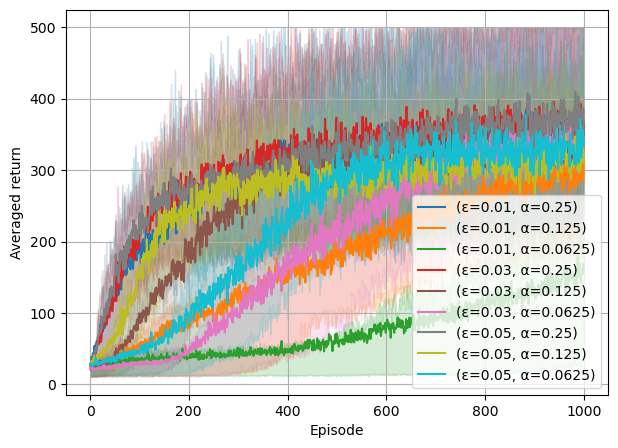

In [661]:
# Load the JSON data from the file
file_path = './test/sarsa_task2.json'  # Make sure to replace this with the actual path to your JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Initialize the figure
plt.figure(figsize=(7, 5))

# Define a color palette for visual distinction
color_palette = plt.cm.tab10(np.linspace(0, 1, len(data)))

# Assuming episodes range from 1 to 1000
episodes = np.arange(1, 1001)

for i, (setting, details) in enumerate(data.items()):
    # Extract performance data
    mean_performance = details['50_trials']['1000_episodes_mean']
    upper_quantile_performance = details['50_trials']['1000_episodes_upper_quantile']
    lower_quantile_performance = details['50_trials']['1000_episodes_lower_quantile']
    
    # Plot mean performance with a specific color and solid line
    plt.plot(episodes, mean_performance, label=f"(ε={details['epsilon']}, α={details['alpha']})",
             color=color_palette[i % len(color_palette)], linestyle='-')
    
    # Add shaded interquantile region
    plt.fill_between(episodes, lower_quantile_performance, upper_quantile_performance, color=color_palette[i % len(color_palette)], alpha=0.2)

# plt.title('Performance of Expected SARSA on CartPole-v1')
plt.xlabel('Episode')
plt.ylabel('Averaged return')
plt.legend()
plt.grid(True)
plt.show()

# Actor-Critic

In [583]:
class ActorCritic:
    def __init__(self, tile_coder, num_actions, temperature, learning_rate_actor, learning_rate_critic, discount_factor):
        self.tile_coder = tile_coder
        self.num_actions = num_actions
        self.temperature = temperature
        self.learning_rate_actor = learning_rate_actor
        self.learning_rate_critic = learning_rate_critic
        self.discount_factor = discount_factor
        
        # Initialize actor (policy) parameters theta for each action
        self.theta = np.random.randn(num_actions, tile_coder.num_tilings * tile_coder.tiles_per_dimension**2)  # Assuming 2D observations for simplicity
        
        # Initialize critic (value function) weights w
        self.w = np.random.randn(tile_coder.num_tilings * tile_coder.tiles_per_dimension**2)
        
    def policy(self, state):
        tile_code = self.tile_coder.get_tile_code(state)
        preferences = np.dot(self.theta, tile_code) / self.temperature
        exp_preferences = np.exp(preferences)
        action_probs = exp_preferences / np.sum(exp_preferences)
        return action_probs
        
    def choose_action(self, state):
        action_probs = self.policy(state)
        action = np.random.choice(np.arange(self.num_actions), p=action_probs)
        return action
        
    def update(self, state, action, reward, next_state, done):
        tile_code = self.tile_coder.get_tile_code(state)
        value = np.dot(self.w, tile_code)
        
        if done:
            td_target = reward
        else:
            next_tile_code = self.tile_coder.get_tile_code(next_state)
            next_value = np.dot(self.w, next_tile_code)
            td_target = reward + self.discount_factor * next_value
        
        td_error = td_target - value
        
        # Critic update
        self.w += self.learning_rate_critic * td_error * tile_code
        
        # Actor update
        action_probs = self.policy(state)
        self.theta[action] += self.learning_rate_actor * (td_error) * (1 - action_probs[action]) * tile_code
        
        # For all non-taken actions
        for a in range(self.num_actions):
            if a != action:
                self.theta[a] -= self.learning_rate_actor * (td_error) * action_probs[a] * tile_code


## Actor-Critic on MountainCar-v0

In [584]:
def run_trial(env, actor_critic, num_episodes, initial_temperature, decreasing_temp=False):
    episode_returns = np.zeros(num_episodes)
    for i in range(num_episodes):
        # Update the temperature for each episode if decreasing_temp is True
        if decreasing_temp:
            # if decreasing_temp & num_episodes>500:
            current_temp = max(initial_temperature * (1 ** 0.99), 0.01)  # Decrease temperature each episode
            actor_critic.temperature = current_temp
        
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = actor_critic.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            actor_critic.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
        episode_returns[i] = total_reward
    return episode_returns

def test_actor_critic_with_temperature(env, num_trials, num_episodes, temperature, decreasing_temp=False):
    trial_returns = np.zeros((num_trials, num_episodes))
    for trial in tqdm(range(num_trials)):
        # Initialize actor_critic with the starting temperature
        actor_critic = ActorCritic(tile_coder, env.action_space.n, temperature, learning_rate_actor, learning_rate_critic, discount_factor)
        trial_returns[trial] = run_trial(env, actor_critic, num_episodes, temperature, decreasing_temp)
    
    # Calculate statistics
    upper_quantile = np.percentile(trial_returns, 75, axis=0)
    mean_returns = np.mean(trial_returns, axis=0)
    lower_quantile = np.percentile(trial_returns, 25, axis=0)
    
    return {
        "1000_episodes_upper_quantile": upper_quantile.tolist(),
        "1000_episodes_mean": mean_returns.tolist(),
        "1000_episodes_lower_quantile": lower_quantile.tolist(),
    }

env = gym.make('MountainCar-v0')
env.seed(0)

num_trials = 50
num_episodes = 1000
temperature = 1.0
temperature_de = 10
learning_rate_actor = 0.1
learning_rate_critic = 0.1
discount_factor = 0.99

# Tile coder setup (adjust parameters as needed)
num_tilings = 2
tiles_per_dimension = 8
tile_coder = TileCoder(num_tilings, tiles_per_dimension, env.observation_space.low, env.observation_space.high)

# Testing fixed temperature setting
fixed_temp_results = test_actor_critic_with_temperature(env, num_trials, num_episodes, temperature)

env = gym.make('MountainCar-v0')
env.seed(0)

# Testing decreasing temperature setting
decreasing_temp_results = test_actor_critic_with_temperature(env, num_trials, num_episodes, temperature_de, decreasing_temp=True)

# Combine results into a single dictionary
results = {
    "setting_fixed_tmp": {
        "50_trials": fixed_temp_results
    },
    "setting_decreasing_tmp": {
        "50_trials": decreasing_temp_results
    }
}

# Saving results to a JSON file
with open("./test/actorCritic_task1.json", "w") as json_file:
    json.dump(results, json_file, indent=4)

results_path = "./test/actorCritic_task1.json"
results_path

100%|██████████| 50/50 [05:36<00:00,  6.73s/it]


'./test/actorCritic_task1.json'

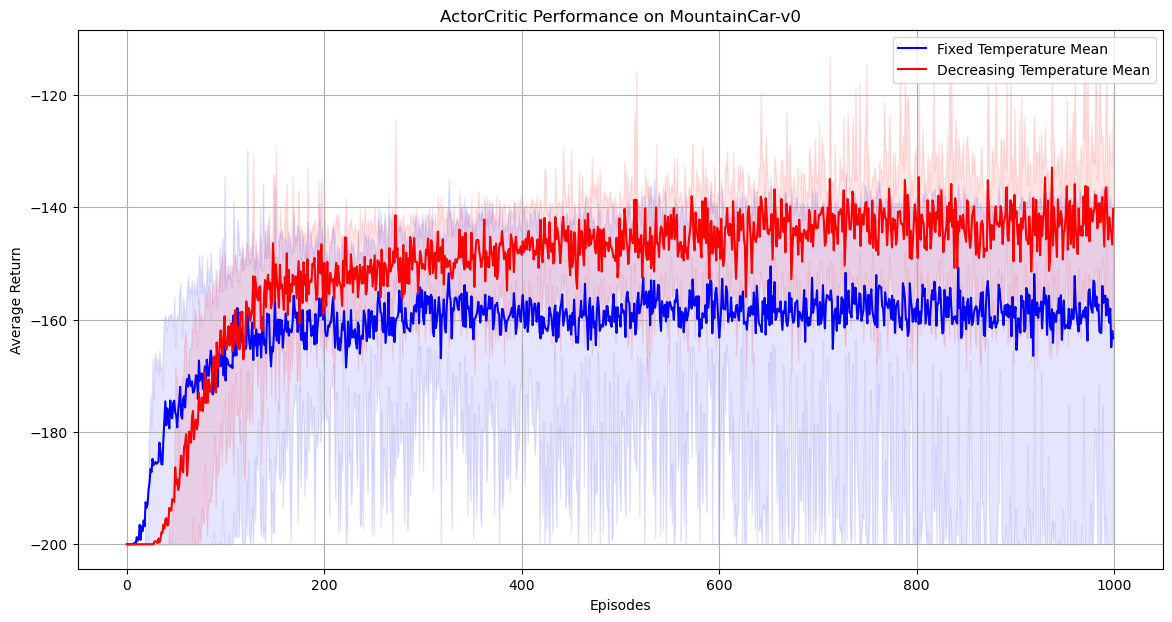

In [585]:
# Load the data
with open("./test/actorCritic_task1.json", "r") as json_file:
    results = json.load(json_file)

# Extract data for plotting
fixed_temp_means = results['setting_fixed_tmp']['50_trials']['1000_episodes_mean']
fixed_temp_upper = results['setting_fixed_tmp']['50_trials']['1000_episodes_upper_quantile']
fixed_temp_lower = results['setting_fixed_tmp']['50_trials']['1000_episodes_lower_quantile']

decreasing_temp_means = results['setting_decreasing_tmp']['50_trials']['1000_episodes_mean']
decreasing_temp_upper = results['setting_decreasing_tmp']['50_trials']['1000_episodes_upper_quantile']
decreasing_temp_lower = results['setting_decreasing_tmp']['50_trials']['1000_episodes_lower_quantile']

# Plotting
plt.figure(figsize=(14, 7))

# Fixed temperature
plt.fill_between(range(1000), fixed_temp_lower, fixed_temp_upper, color='blue', alpha=0.1)
plt.plot(fixed_temp_means, label='Fixed Temperature Mean', color='blue')

# Decreasing temperature
plt.fill_between(range(1000), decreasing_temp_lower, decreasing_temp_upper, color='red', alpha=0.1)
plt.plot(decreasing_temp_means, label='Decreasing Temperature Mean', color='red')

plt.title('ActorCritic Performance on MountainCar-v0')
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.legend()
plt.grid(True)
plt.show()

In [586]:
class ActorCritic:
    def __init__(self, tile_coder, num_actions, temperature, learning_rate_actor, learning_rate_critic, discount_factor):
        self.tile_coder = tile_coder
        self.num_actions = num_actions
        self.temperature = temperature
        self.learning_rate_actor = learning_rate_actor
        self.learning_rate_critic = learning_rate_critic
        self.discount_factor = discount_factor
        
        # Assuming 4D observation space and adjusting initialization accordingly
        num_features = tile_coder.num_tilings * (tile_coder.tiles_per_dimension ** 4)  # Adjusted for 4D observation space
        self.theta = np.random.randn(num_actions, num_features)
        self.w = np.random.randn(num_features)
        
    def policy(self, state):
        tile_code = self.tile_coder.get_tile_code(state)
        preferences = np.dot(self.theta, tile_code) / self.temperature
        exp_preferences = np.exp(preferences)
        action_probs = exp_preferences / np.sum(exp_preferences)
        return action_probs
        
    def choose_action(self, state):
        action_probs = self.policy(state)
        action = np.random.choice(np.arange(self.num_actions), p=action_probs)
        return action
        
    def update(self, state, action, reward, next_state, done):
        tile_code = self.tile_coder.get_tile_code(state)
        value = np.dot(self.w, tile_code)
        
        if done:
            td_target = reward
        else:
            next_tile_code = self.tile_coder.get_tile_code(next_state)
            next_value = np.dot(self.w, next_tile_code)
            td_target = reward + self.discount_factor * next_value
        
        td_error = td_target - value
        
        # Critic update
        self.w += self.learning_rate_critic * td_error * tile_code
        
        # Actor update
        action_probs = self.policy(state)
        self.theta[action] += self.learning_rate_actor * (td_error) * (1 - action_probs[action]) * tile_code
        
        # For all non-taken actions
        for a in range(self.num_actions):
            if a != action:
                self.theta[a] -= self.learning_rate_actor * (td_error) * action_probs[a] * tile_code

## Actor-Critic on CartPole-v1

In [587]:
def run_trial(env, actor_critic, num_episodes, initial_temperature, decreasing_temp=False):
    episode_returns = np.zeros(num_episodes)
    for i in range(num_episodes):
        # Adjust temperature for each episode if decreasing_temp is True
        if decreasing_temp:
            # if decreasing_temp & num_episodes > 500:
            current_temp = max(initial_temperature * (0.995 ** i), 0.5)  # Decrease temperature each episode
            actor_critic.temperature = current_temp
        
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = actor_critic.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            actor_critic.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
        episode_returns[i] = total_reward
    return episode_returns

def test_actor_critic_with_temperature(env, num_trials, num_episodes, temperature, decreasing_temp=False):
    trial_returns = np.zeros((num_trials, num_episodes))
    for trial in tqdm(range(num_trials)):
        actor_critic = ActorCritic(tile_coder, env.action_space.n, temperature, learning_rate_actor, learning_rate_critic, discount_factor)
        trial_returns[trial] = run_trial(env, actor_critic, num_episodes, temperature, decreasing_temp)
    
    upper_quantile = np.percentile(trial_returns, 75, axis=0)
    mean_returns = np.mean(trial_returns, axis=0)
    lower_quantile = np.percentile(trial_returns, 25, axis=0)
    
    return {
        "1000_episodes_upper_quantile": upper_quantile.tolist(),
        "1000_episodes_mean": mean_returns.tolist(),
        "1000_episodes_lower_quantile": lower_quantile.tolist(),
    }

env = gym.make('CartPole-v1')
env.seed(0)

num_trials = 50
num_episodes = 1000
temperature = 1.0
temperature_de = 10
learning_rate_actor = 0.1
learning_rate_critic = 0.1
discount_factor = 0.99

# Manually setting bounds for CartPole-v1's observation space
env_low = np.array([-2.4, -2, -0.418, -2])  # Adjusted based on the environment's specifics
env_high = np.array([2.4, 2, 0.418, 2])     # Adjusted based on the environment's specifics

# Ensure TileCoder properly encodes the 4D observation space
num_tilings = 4
tiles_per_dimension = 10  # Consider how this affects the total number of features
tile_coder = TileCoder(num_tilings, tiles_per_dimension, env_low, env_high)

os.makedirs("./test/", exist_ok=True)

# Test with fixed temperature
fixed_temp_results = test_actor_critic_with_temperature(env, num_trials, num_episodes, temperature)

env = gym.make('CartPole-v1')
env.seed(0)

# Test with decreasing temperature
decreasing_temp_results = test_actor_critic_with_temperature(env, num_trials, num_episodes, temperature_de, decreasing_temp=True)

# Combine results into a dictionary
results = {
    "setting_fixed_tmp": {
        "50_trials": fixed_temp_results
    },
    "setting_decreasing_tmp": {
        "50_trials": decreasing_temp_results
    }
}

# Save the results to a JSON file
with open("./test/actorCritic_task2.json", "w") as json_file:
    json.dump(results, json_file, indent=4)

print("Results saved to ./test/actorCritic_task2.json")


100%|██████████| 50/50 [42:32<00:00, 51.05s/it]

Results saved to ./test/actorCritic_task2.json


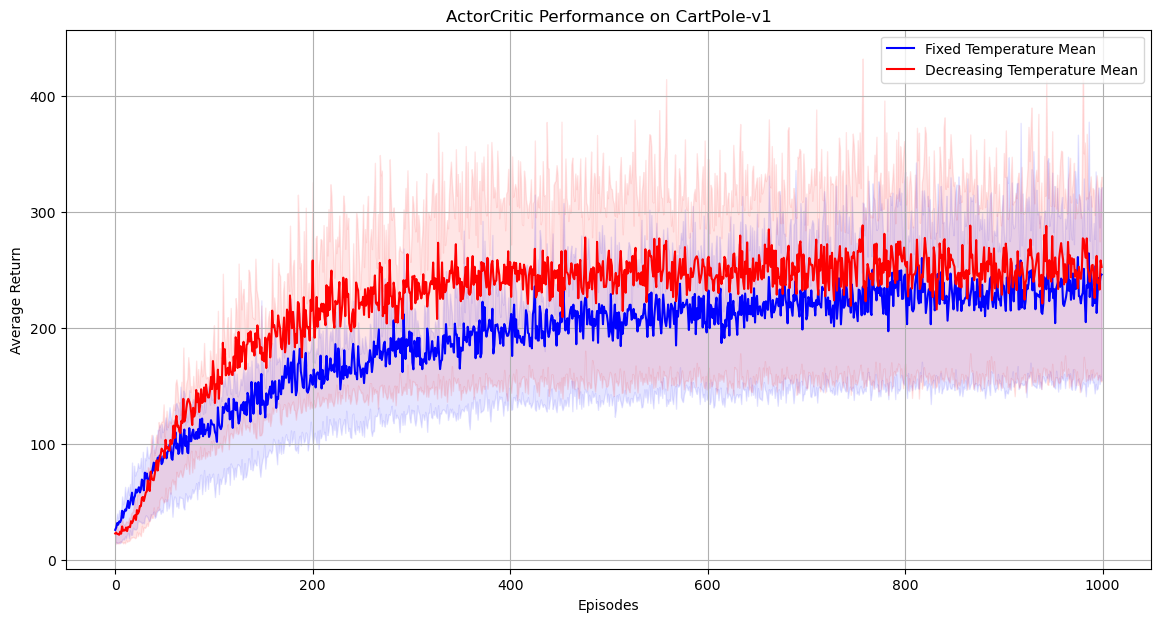

In [626]:
# Load the data
with open("./test/actorCritic_task2.json", "r") as json_file:
    results = json.load(json_file)

# Extract data for plotting
fixed_temp_means = results['setting_fixed_tmp']['50_trials']['1000_episodes_mean']
fixed_temp_upper = results['setting_fixed_tmp']['50_trials']['1000_episodes_upper_quantile']
fixed_temp_lower = results['setting_fixed_tmp']['50_trials']['1000_episodes_lower_quantile']

decreasing_temp_means = results['setting_decreasing_tmp']['50_trials']['1000_episodes_mean']
decreasing_temp_upper = results['setting_decreasing_tmp']['50_trials']['1000_episodes_upper_quantile']
decreasing_temp_lower = results['setting_decreasing_tmp']['50_trials']['1000_episodes_lower_quantile']

# Plotting
plt.figure(figsize=(14, 7))

# Fixed temperature
plt.fill_between(range(1000), fixed_temp_lower, fixed_temp_upper, color='blue', alpha=0.1)
plt.plot(fixed_temp_means, label='Fixed Temperature Mean', color='blue')

# Decreasing temperature
plt.fill_between(range(1000), decreasing_temp_lower, decreasing_temp_upper, color='red', alpha=0.1)
plt.plot(decreasing_temp_means, label='Decreasing Temperature Mean', color='red')

plt.title('ActorCritic Performance on CartPole-v1')
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.legend()
plt.grid(True)
plt.show()


# REINFORCE

In [662]:
class REINFORCE:
    def __init__(self, tile_coder, num_actions, learning_rate=0.01, gamma=0.99, temperature=1.0):
        self.tile_coder = tile_coder
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.temperature = temperature
        self.theta = np.random.rand(num_actions, tile_coder.num_tilings * tile_coder.tiles_per_dimension**2) * 0.01  # Random initialization of policy parameters
        
    def policy(self, state):
        x = self.tile_coder.get_tile_code(state)  # Get tile-coded state
        z = np.dot(self.theta, x)  # Compute z values for all actions
        exp_z = np.exp(z / self.temperature)
        policy = exp_z / np.sum(exp_z)  # Softmax
        return policy
    
    def choose_action(self, state):
        policy = self.policy(state)
        action = np.random.choice(range(self.num_actions), p=policy)  # Choose action based on policy probabilities
        return action
    
    def update(self, states, actions, rewards):
        G = 0
        for t in reversed(range(len(states))):
            x = self.tile_coder.get_tile_code(states[t])
            G = self.gamma * G + rewards[t]
            probs = self.policy(states[t])
            dlog = -probs  # derivative of log pi for all actions
            dlog[actions[t]] += 1  # For taken action
            for a in range(self.num_actions):
                self.theta[a] += self.learning_rate * G * dlog[a] * x

## REINFORCE on MountainCar-v0

In [665]:
def run_experiment(setting, num_trials, num_episodes, env_name='MountainCar-v0'):
    env = gym.make(env_name)
    env.seed(0)
    num_actions = env.action_space.n
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    tile_coder = TileCoder(2, 10, env_low, env_high)
    trial_rewards = np.zeros((num_trials, num_episodes))

    for trial in tqdm(range(num_trials)):
        # Set initial temperature based on the setting
        temperature = 1.0 if setting == "fixed_temperature" else 10.0  # Start with 1.0 for decreasing
        agent = REINFORCE(tile_coder, num_actions, learning_rate=0.99, gamma=0.995, temperature=temperature)
        
        for episode in range(num_episodes):
            state = env.reset()
            episode_rewards = []
            done = False
            
            while not done:
                action = agent.choose_action(state)
                next_state, reward, done, _ = env.step(action)
                episode_rewards.append(reward)
                state = next_state
            
            # Update agent for the episode
            agent.update([state], [action], episode_rewards)
            
            # Adjust temperature for decreasing temperature setting
            if setting == "decreasing_temperature":
                agent.temperature = max(0.1, agent.temperature * 0.995)  # Example: decrease by 1% each episode, no lower than 0.1

            # Store the sum of episode rewards
            trial_rewards[trial, episode] = sum(episode_rewards)

    return trial_rewards

def analyze_results(trial_rewards):
    upper_quantile = np.percentile(trial_rewards, 75, axis=0)
    mean_rewards = np.mean(trial_rewards, axis=0)
    lower_quantile = np.percentile(trial_rewards, 25, axis=0)
    return upper_quantile, mean_rewards, lower_quantile

num_trials = 5
num_episodes = 1000

settings = ["setting_fixed_tmp", "setting_decreasing_tmp"]
results = {}

for setting in settings:
    trial_rewards = run_experiment(setting, num_trials, num_episodes)
    upper_quantile, mean_rewards, lower_quantile = analyze_results(trial_rewards)
    results[setting] = {
        "50_trials": {
            "1000_episodes_upper_quantile": upper_quantile.tolist(),
            "1000_episodes_mean": mean_rewards.tolist(),
            "1000_episodes_lower_quantile": lower_quantile.tolist(),
        }
    }

# Save results to JSON file
output_path = Path("./test/REINFORCE_task1.json")
output_path.parent.mkdir(parents=True, exist_ok=True)
with open(output_path, "w") as fp:
    json.dump(results, fp)

print("Experiment results saved.")

100%|██████████| 5/5 [00:39<00:00,  7.83s/it]

Experiment results saved.


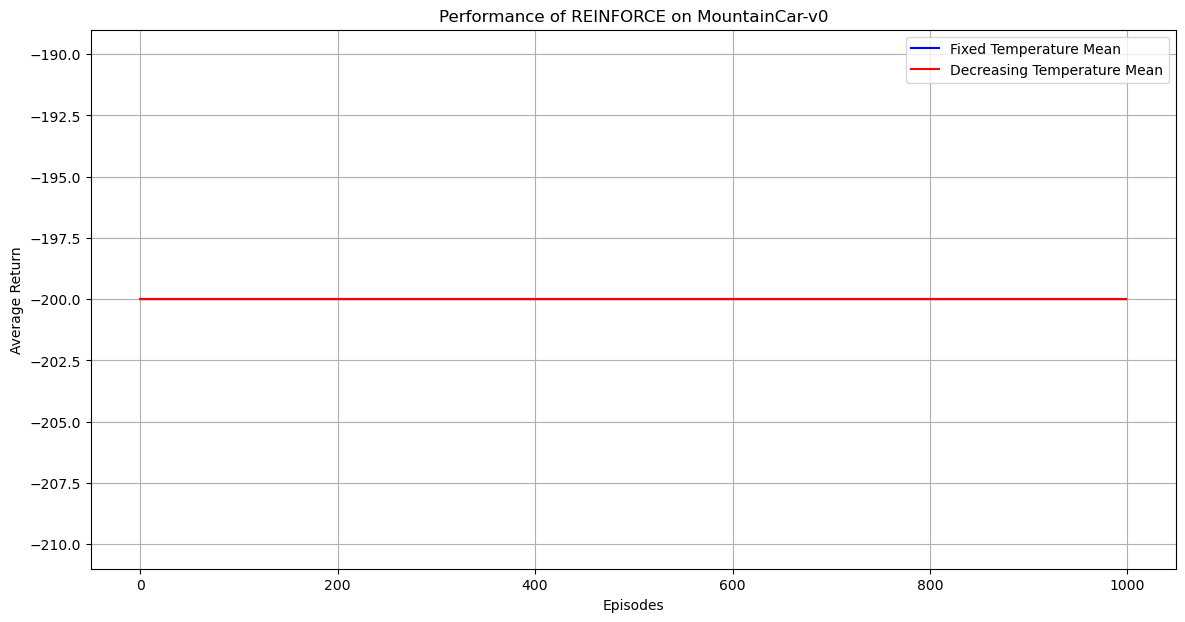

In [666]:
# Load the data
with open("./test/REINFORCE_task1.json", "r") as json_file:
    results = json.load(json_file)

# Extract data for plotting
fixed_temp_means = results['setting_fixed_tmp']['50_trials']['1000_episodes_mean']
fixed_temp_upper = results['setting_fixed_tmp']['50_trials']['1000_episodes_upper_quantile']
fixed_temp_lower = results['setting_fixed_tmp']['50_trials']['1000_episodes_lower_quantile']

decreasing_temp_means = results['setting_decreasing_tmp']['50_trials']['1000_episodes_mean']
decreasing_temp_upper = results['setting_decreasing_tmp']['50_trials']['1000_episodes_upper_quantile']
decreasing_temp_lower = results['setting_decreasing_tmp']['50_trials']['1000_episodes_lower_quantile']

# Plotting
plt.figure(figsize=(14, 7))

# Fixed temperature
plt.fill_between(range(1000), fixed_temp_lower, fixed_temp_upper, color='blue', alpha=0.1)
plt.plot(fixed_temp_means, label='Fixed Temperature Mean', color='blue')

# Decreasing temperature
plt.fill_between(range(1000), decreasing_temp_lower, decreasing_temp_upper, color='red', alpha=0.1)
plt.plot(decreasing_temp_means, label='Decreasing Temperature Mean', color='red')

plt.title('Performance of REINFORCE on MountainCar-v0')
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.legend()
plt.grid(True)
plt.show()

In [536]:
class REINFORCE:
    def __init__(self, tile_coder, num_actions, learning_rate=0.01, gamma=0.99, temperature=1.0):
        self.tile_coder = tile_coder
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.temperature = temperature
        # Dynamically adjust theta's shape based on tile_coder output size
        feature_vector_size = len(tile_coder.get_tile_code([0.0] * len(env.observation_space.high)))
        self.theta = np.random.rand(num_actions, feature_vector_size) * 0.01  # Adjusted initialization
        
    def policy(self, state):
        x = self.tile_coder.get_tile_code(state)  # Get tile-coded state
        z = np.dot(self.theta, x)  # Compute z values for all actions
        exp_z = np.exp(z / self.temperature)
        policy = exp_z / np.sum(exp_z)  # Softmax
        return policy
    
    def choose_action(self, state):
        policy = self.policy(state)
        action = np.random.choice(range(self.num_actions), p=policy)  # Choose action based on policy probabilities
        return action
    
    def update(self, states, actions, rewards):
        G = 0
        for t in reversed(range(len(states))):
            x = self.tile_coder.get_tile_code(states[t])
            G = self.gamma * G + rewards[t]
            probs = self.policy(states[t])
            dlog = -probs  # derivative of log pi for all actions
            dlog[actions[t]] += 1  # For taken action
            for a in range(self.num_actions):
                self.theta[a] += self.learning_rate * G * dlog[a] * x

## REINFORCE on CartPole-v1

In [581]:
def update_temperature(temperature, discount_rate_change, min_temp):
    return max(min_temp, temperature * discount_rate_change)

def run_trials(env_name, num_trials, num_episodes, tile_coder, fixed_temp, initial_temp, discount_rate_change, min_temp):
    settings = ["setting_fixed_tmp", "setting_decreasing_tmp"]
    results = {}
    env = gym.make(env_name) 
    env.seed(123)

    for setting in settings:
        all_rewards = np.zeros((num_trials, num_episodes))
        for trial in tqdm(range(num_trials)):
            num_actions = env.action_space.n
            temperature = fixed_temp if setting == "setting_fixed_tmp" else initial_temp
            agent = REINFORCE(tile_coder, num_actions, learning_rate=0.2, gamma=0.998, temperature=temperature)
            
            for episode in range(num_episodes):
                if setting == "setting_decreasing_tmp":
                    # Adjust the temperature for decreasing temperature setting using the exponential decrease
                    temperature = update_temperature(temperature, discount_rate_change, min_temp)
                    agent.temperature = temperature
                state, done, ep_rewards = env.reset(), False, 0
                
                while not done:
                    action = agent.choose_action(state)
                    next_state, reward, done, _ = env.step(action)
                    agent.update([state], [action], [reward])
                    state = next_state
                    ep_rewards += reward
                
                all_rewards[trial, episode] = ep_rewards
                
        results[setting] = {
            "50_trials": {
                "1000_episodes_upper_quantile": np.percentile(all_rewards, 75, axis=0).tolist(),
                "1000_episodes_mean": np.mean(all_rewards, axis=0).tolist(),
                "1000_episodes_lower_quantile": np.percentile(all_rewards, 25, axis=0).tolist(),
            }
        }

    return results

# Adjusted parameters and environment settings
env_low = np.array([-2.4, -2, -0.418, -2]) 
env_high = np.array([2.4, 2, 0.418, 2])
tile_coder = TileCoder(4, 8, env_low, env_high)

fixed_temp = 1  # Fixed temperature for setting 1
initial_temp = 10  # Initial temperature for setting 2
discount_rate_change = 0.995  # Use to discount temperature in setting 2 each episode
min_temp = 0.1  # Minimum temperature for setting 2

num_trials = 50
num_episodes = 1000
env_name = 'CartPole-v1'

# Run trials and save results
results = run_trials(env_name, num_trials, num_episodes, tile_coder, fixed_temp, initial_temp, discount_rate_change, min_temp)

# Save results to JSON file
output_path = Path("./test/REINFORCE_task2.json")
output_path.parent.mkdir(parents=True, exist_ok=True)
with open(output_path, "w") as fp:
    json.dump(results, fp)

print("Experiment results saved.")

100%|██████████| 50/50 [02:41<00:00,  3.23s/it]

Experiment results saved.


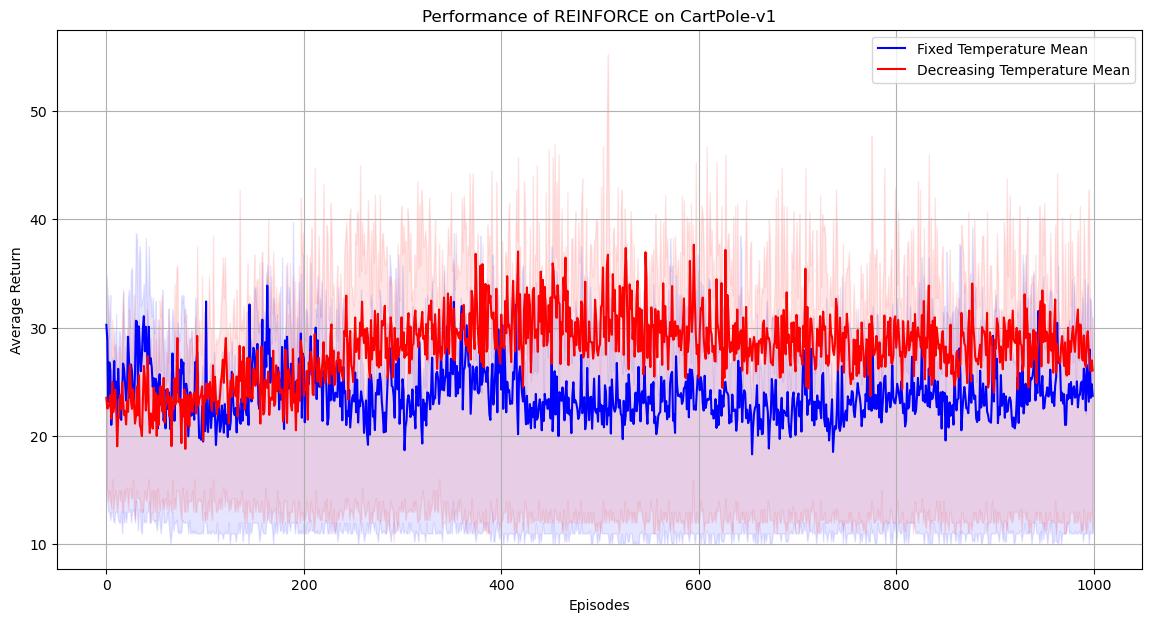

In [628]:
# Load the data
with open("./test/REINFORCE_task2.json", "r") as json_file:
    results = json.load(json_file)

# Extract data for plotting
fixed_temp_means = results['setting_fixed_tmp']['50_trials']['1000_episodes_mean']
fixed_temp_upper = results['setting_fixed_tmp']['50_trials']['1000_episodes_upper_quantile']
fixed_temp_lower = results['setting_fixed_tmp']['50_trials']['1000_episodes_lower_quantile']

decreasing_temp_means = results['setting_decreasing_tmp']['50_trials']['1000_episodes_mean']
decreasing_temp_upper = results['setting_decreasing_tmp']['50_trials']['1000_episodes_upper_quantile']
decreasing_temp_lower = results['setting_decreasing_tmp']['50_trials']['1000_episodes_lower_quantile']

# Plotting
plt.figure(figsize=(14, 7))

# Fixed temperature
plt.fill_between(range(1000), fixed_temp_lower, fixed_temp_upper, color='blue', alpha=0.1)
plt.plot(fixed_temp_means, label='Fixed Temperature Mean', color='blue')

# Decreasing temperature
plt.fill_between(range(1000), decreasing_temp_lower, decreasing_temp_upper, color='red', alpha=0.1)
plt.plot(decreasing_temp_means, label='Decreasing Temperature Mean', color='red')

plt.title('Performance of REINFORCE on CartPole-v1')
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.legend()
plt.grid(True)
plt.show()

## Plots

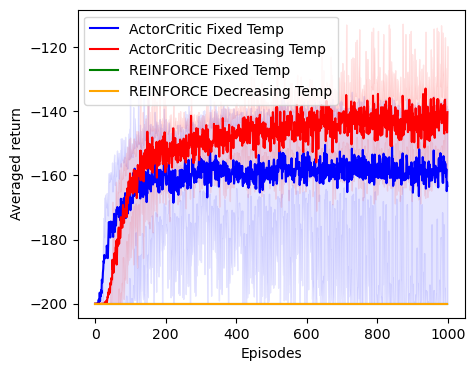

In [658]:
with open('./test/actorCritic_task1.json', 'r') as file:
    actorCritic_data = json.load(file)

with open('./test/REINFORCE_task1.json', 'r') as file:
    reinforce_data = json.load(file)

# Extracting the necessary data
actorCritic_fixed_upper = actorCritic_data['setting_fixed_tmp']['50_trials']['1000_episodes_upper_quantile']
actorCritic_fixed_mean = actorCritic_data['setting_fixed_tmp']['50_trials']['1000_episodes_mean']
actorCritic_fixed_lower = actorCritic_data['setting_fixed_tmp']['50_trials']['1000_episodes_lower_quantile']

actorCritic_decreasing_upper = actorCritic_data['setting_decreasing_tmp']['50_trials']['1000_episodes_upper_quantile']
actorCritic_decreasing_mean = actorCritic_data['setting_decreasing_tmp']['50_trials']['1000_episodes_mean']
actorCritic_decreasing_lower = actorCritic_data['setting_decreasing_tmp']['50_trials']['1000_episodes_lower_quantile']

reinforce_fixed_upper = reinforce_data['setting_fixed_tmp']['50_trials']['1000_episodes_upper_quantile']
reinforce_fixed_mean = reinforce_data['setting_fixed_tmp']['50_trials']['1000_episodes_mean']
reinforce_fixed_lower = reinforce_data['setting_fixed_tmp']['50_trials']['1000_episodes_lower_quantile']

reinforce_decreasing_upper = reinforce_data['setting_decreasing_tmp']['50_trials']['1000_episodes_upper_quantile']
reinforce_decreasing_mean = reinforce_data['setting_decreasing_tmp']['50_trials']['1000_episodes_mean']
reinforce_decreasing_lower = reinforce_data['setting_decreasing_tmp']['50_trials']['1000_episodes_lower_quantile']

# Setting up the plot
plt.figure(figsize=(5, 4))

# ActorCritic Fixed Temp
plt.plot(actorCritic_fixed_mean, label='ActorCritic Fixed Temp', color='blue')
plt.fill_between(range(len(actorCritic_fixed_upper)), actorCritic_fixed_lower, actorCritic_fixed_upper, color='blue', alpha=0.1)

# ActorCritic Decreasing Temp
plt.plot(actorCritic_decreasing_mean, label='ActorCritic Decreasing Temp', color='red')
plt.fill_between(range(len(actorCritic_decreasing_upper)), actorCritic_decreasing_lower, actorCritic_decreasing_upper, color='red', alpha=0.1)

# REINFORCE Fixed Temp
plt.plot(reinforce_fixed_mean, label='REINFORCE Fixed Temp', color='green')
plt.fill_between(range(len(reinforce_fixed_upper)), reinforce_fixed_lower, reinforce_fixed_upper, color='green', alpha=0.1)

# REINFORCE Decreasing Temp
plt.plot(reinforce_decreasing_mean, label='REINFORCE Decreasing Temp', color='orange')
plt.fill_between(range(len(reinforce_decreasing_upper)), reinforce_decreasing_lower, reinforce_decreasing_upper, color='orange', alpha=0.1)

# plt.title('Performance of ActorCritic and REINFORCE on MountainCar-v0')
plt.xlabel('Episodes')
plt.ylabel('Averaged return')
plt.legend()
plt.show()

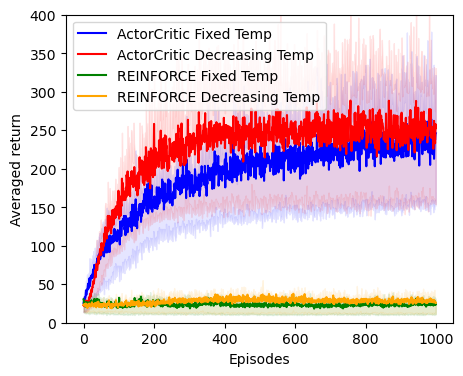

In [660]:
with open('./test/actorCritic_task2.json', 'r') as file:
    actorCritic_data = json.load(file)

with open('./test/REINFORCE_task2.json', 'r') as file:
    reinforce_data = json.load(file)

# Extracting the necessary data
actorCritic_fixed_upper = actorCritic_data['setting_fixed_tmp']['50_trials']['1000_episodes_upper_quantile']
actorCritic_fixed_mean = actorCritic_data['setting_fixed_tmp']['50_trials']['1000_episodes_mean']
actorCritic_fixed_lower = actorCritic_data['setting_fixed_tmp']['50_trials']['1000_episodes_lower_quantile']

actorCritic_decreasing_upper = actorCritic_data['setting_decreasing_tmp']['50_trials']['1000_episodes_upper_quantile']
actorCritic_decreasing_mean = actorCritic_data['setting_decreasing_tmp']['50_trials']['1000_episodes_mean']
actorCritic_decreasing_lower = actorCritic_data['setting_decreasing_tmp']['50_trials']['1000_episodes_lower_quantile']

reinforce_fixed_upper = reinforce_data['setting_fixed_tmp']['50_trials']['1000_episodes_upper_quantile']
reinforce_fixed_mean = reinforce_data['setting_fixed_tmp']['50_trials']['1000_episodes_mean']
reinforce_fixed_lower = reinforce_data['setting_fixed_tmp']['50_trials']['1000_episodes_lower_quantile']

reinforce_decreasing_upper = reinforce_data['setting_decreasing_tmp']['50_trials']['1000_episodes_upper_quantile']
reinforce_decreasing_mean = reinforce_data['setting_decreasing_tmp']['50_trials']['1000_episodes_mean']
reinforce_decreasing_lower = reinforce_data['setting_decreasing_tmp']['50_trials']['1000_episodes_lower_quantile']

# Setting up the plot
plt.figure(figsize=(5, 4))

# ActorCritic Fixed Temp
plt.plot(actorCritic_fixed_mean, label='ActorCritic Fixed Temp', color='blue')
plt.fill_between(range(len(actorCritic_fixed_upper)), actorCritic_fixed_lower, actorCritic_fixed_upper, color='blue', alpha=0.1)

# ActorCritic Decreasing Temp
plt.plot(actorCritic_decreasing_mean, label='ActorCritic Decreasing Temp', color='red')
plt.fill_between(range(len(actorCritic_decreasing_upper)), actorCritic_decreasing_lower, actorCritic_decreasing_upper, color='red', alpha=0.1)

# REINFORCE Fixed Temp
plt.plot(reinforce_fixed_mean, label='REINFORCE Fixed Temp', color='green')
plt.fill_between(range(len(reinforce_fixed_upper)), reinforce_fixed_lower, reinforce_fixed_upper, color='green', alpha=0.1)

# REINFORCE Decreasing Temp
plt.plot(reinforce_decreasing_mean, label='REINFORCE Decreasing Temp', color='orange')
plt.fill_between(range(len(reinforce_decreasing_upper)), reinforce_decreasing_lower, reinforce_decreasing_upper, color='orange', alpha=0.1)

# plt.title('Performance of ActorCritic and REINFORCE on CartPole-v1')  
plt.xlabel('Episodes')
plt.ylabel('Averaged return')
plt.legend()
plt.ylim(0,400)
plt.show()